In [251]:
import os
import pandas as pd
import ROOT
import csv
import uproot
import numpy as np
import mplhep as hep
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from array import array
from tqdm import trange, tqdm
import random
import time 
import hist
from uncertainties import unumpy as unp
from IPython.display import display, Image

In [289]:
def normalize_histogram_with_uncertainty(histogram, input_format=None, output_format=None, flow=False):
    """
    Normalize a histogram with uncertainty propagation and support for uproot, ROOT, and hist.Hist formats.

    Args:
        histogram: Input histogram (uproot, ROOT, or hist.Hist).
        input_format (str): Format of the input histogram ("uproot", "ROOT", or "hist.Hist").
        output_format (str): Desired format of the output histogram ("uproot", "ROOT", or "hist.Hist").
        flow (bool): Whether to include underflow and overflow bins in normalization.

    Returns:
        Normalized histogram in the specified output format.
    """
    # Detect input format if not specified
    if input_format is None:
        if isinstance(histogram, hist.Hist):
            input_format = "hist"
        elif isinstance(histogram, ROOT.TH1):
            input_format = "ROOT"
        elif hasattr(histogram, "values") and hasattr(histogram, "axes"):
            input_format = "uproot"
        else:
            raise ValueError("Unable to detect input histogram format. Specify input_format.")

    # Extract values, variances, and edges based on input format
    if input_format == "hist":
        values = histogram.values(flow=flow)
        variances = histogram.variances(flow=flow)
        edges = histogram.axes[0].edges
    elif input_format == "ROOT":
        values = np.array([histogram.GetBinContent(i + 1) for i in range(histogram.GetNbinsX())])
        variances = np.array([histogram.GetBinError(i + 1) ** 2 for i in range(histogram.GetNbinsX())])
        edges = np.array([histogram.GetBinLowEdge(i + 1) for i in range(histogram.GetNbinsX() + 1)])
    elif input_format == "uproot":
        values = histogram.values()
        variances = histogram.variances()
        edges = histogram.axes[0].edges()
    else:
        raise ValueError("Unsupported input_format. Use 'uproot', 'ROOT', or 'hist.Hist'.")

    # Handle cases with no entries
    total_value = np.sum(values)
    if total_value == 0:
        return histogram  # Return as-is if total is zero

    # Create array with uncertainties
    values_with_uncert = unp.uarray(values, np.sqrt(variances))

    # Normalize values with uncertainty
    normalized_values = values_with_uncert / total_value

    # Generate output based on requested format
    if output_format is None:
        output_format = input_format  # Default to the same format as input

    if output_format == "hist":
        normalized_hist = hist.Hist(
            histogram.axes[0],
            storage=hist.storage.Weight()
        )
        normalized_hist[...] = (
            unp.nominal_values(normalized_values),
            unp.std_devs(normalized_values) ** 2
        )
        return normalized_hist

    elif output_format == "ROOT":
        h_density = ROOT.TH1D("normalized", "Normalized Histogram", len(values), edges[0], edges[-1])
        for i in range(len(values)):
            h_density.SetBinContent(i + 1, unp.nominal_values(normalized_values)[i])
            h_density.SetBinError(i + 1, unp.std_devs(normalized_values)[i])
        return h_density

    elif output_format == "uproot":
        h_density = hist.Hist.new.Reg(len(values), edges[0], edges[-1], name="normalized").Double()
        h_density.view(flow=False)[...] = unp.nominal_values(normalized_values)
        h_density.variances(flow=False)[...] = unp.std_devs(normalized_values) ** 2
        return h_density

    else:
        raise ValueError("Unsupported output_format. Use 'uproot', 'ROOT', or 'hist.Hist'.")

# Example usage
# Assuming `h` is a histogram in one of the supported formats
# normalized_h = normalize_histogram_with_uncertainty(h, input_format="ROOT", output_format="hist.Hist")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


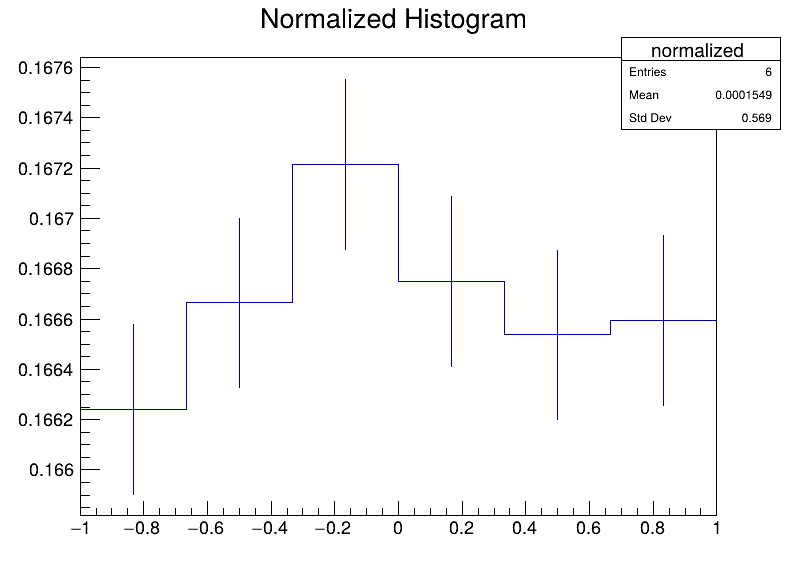

In [290]:
normalized_hist = normalize_histogram_with_uncertainty(test_hist['TTbarSpinDensityMatrix/b1j_absolute_part_cut_0;1'], input_format='uproot', output_format='ROOT')

# Draw the normalized histogram
canvas = ROOT.TCanvas("canvas", "Normalized Histogram", 800, 600)
normalized_hist.Draw("HIST E")  # "HIST E" for histogram with error bars
canvas.Draw()

(0.0, 132.0)

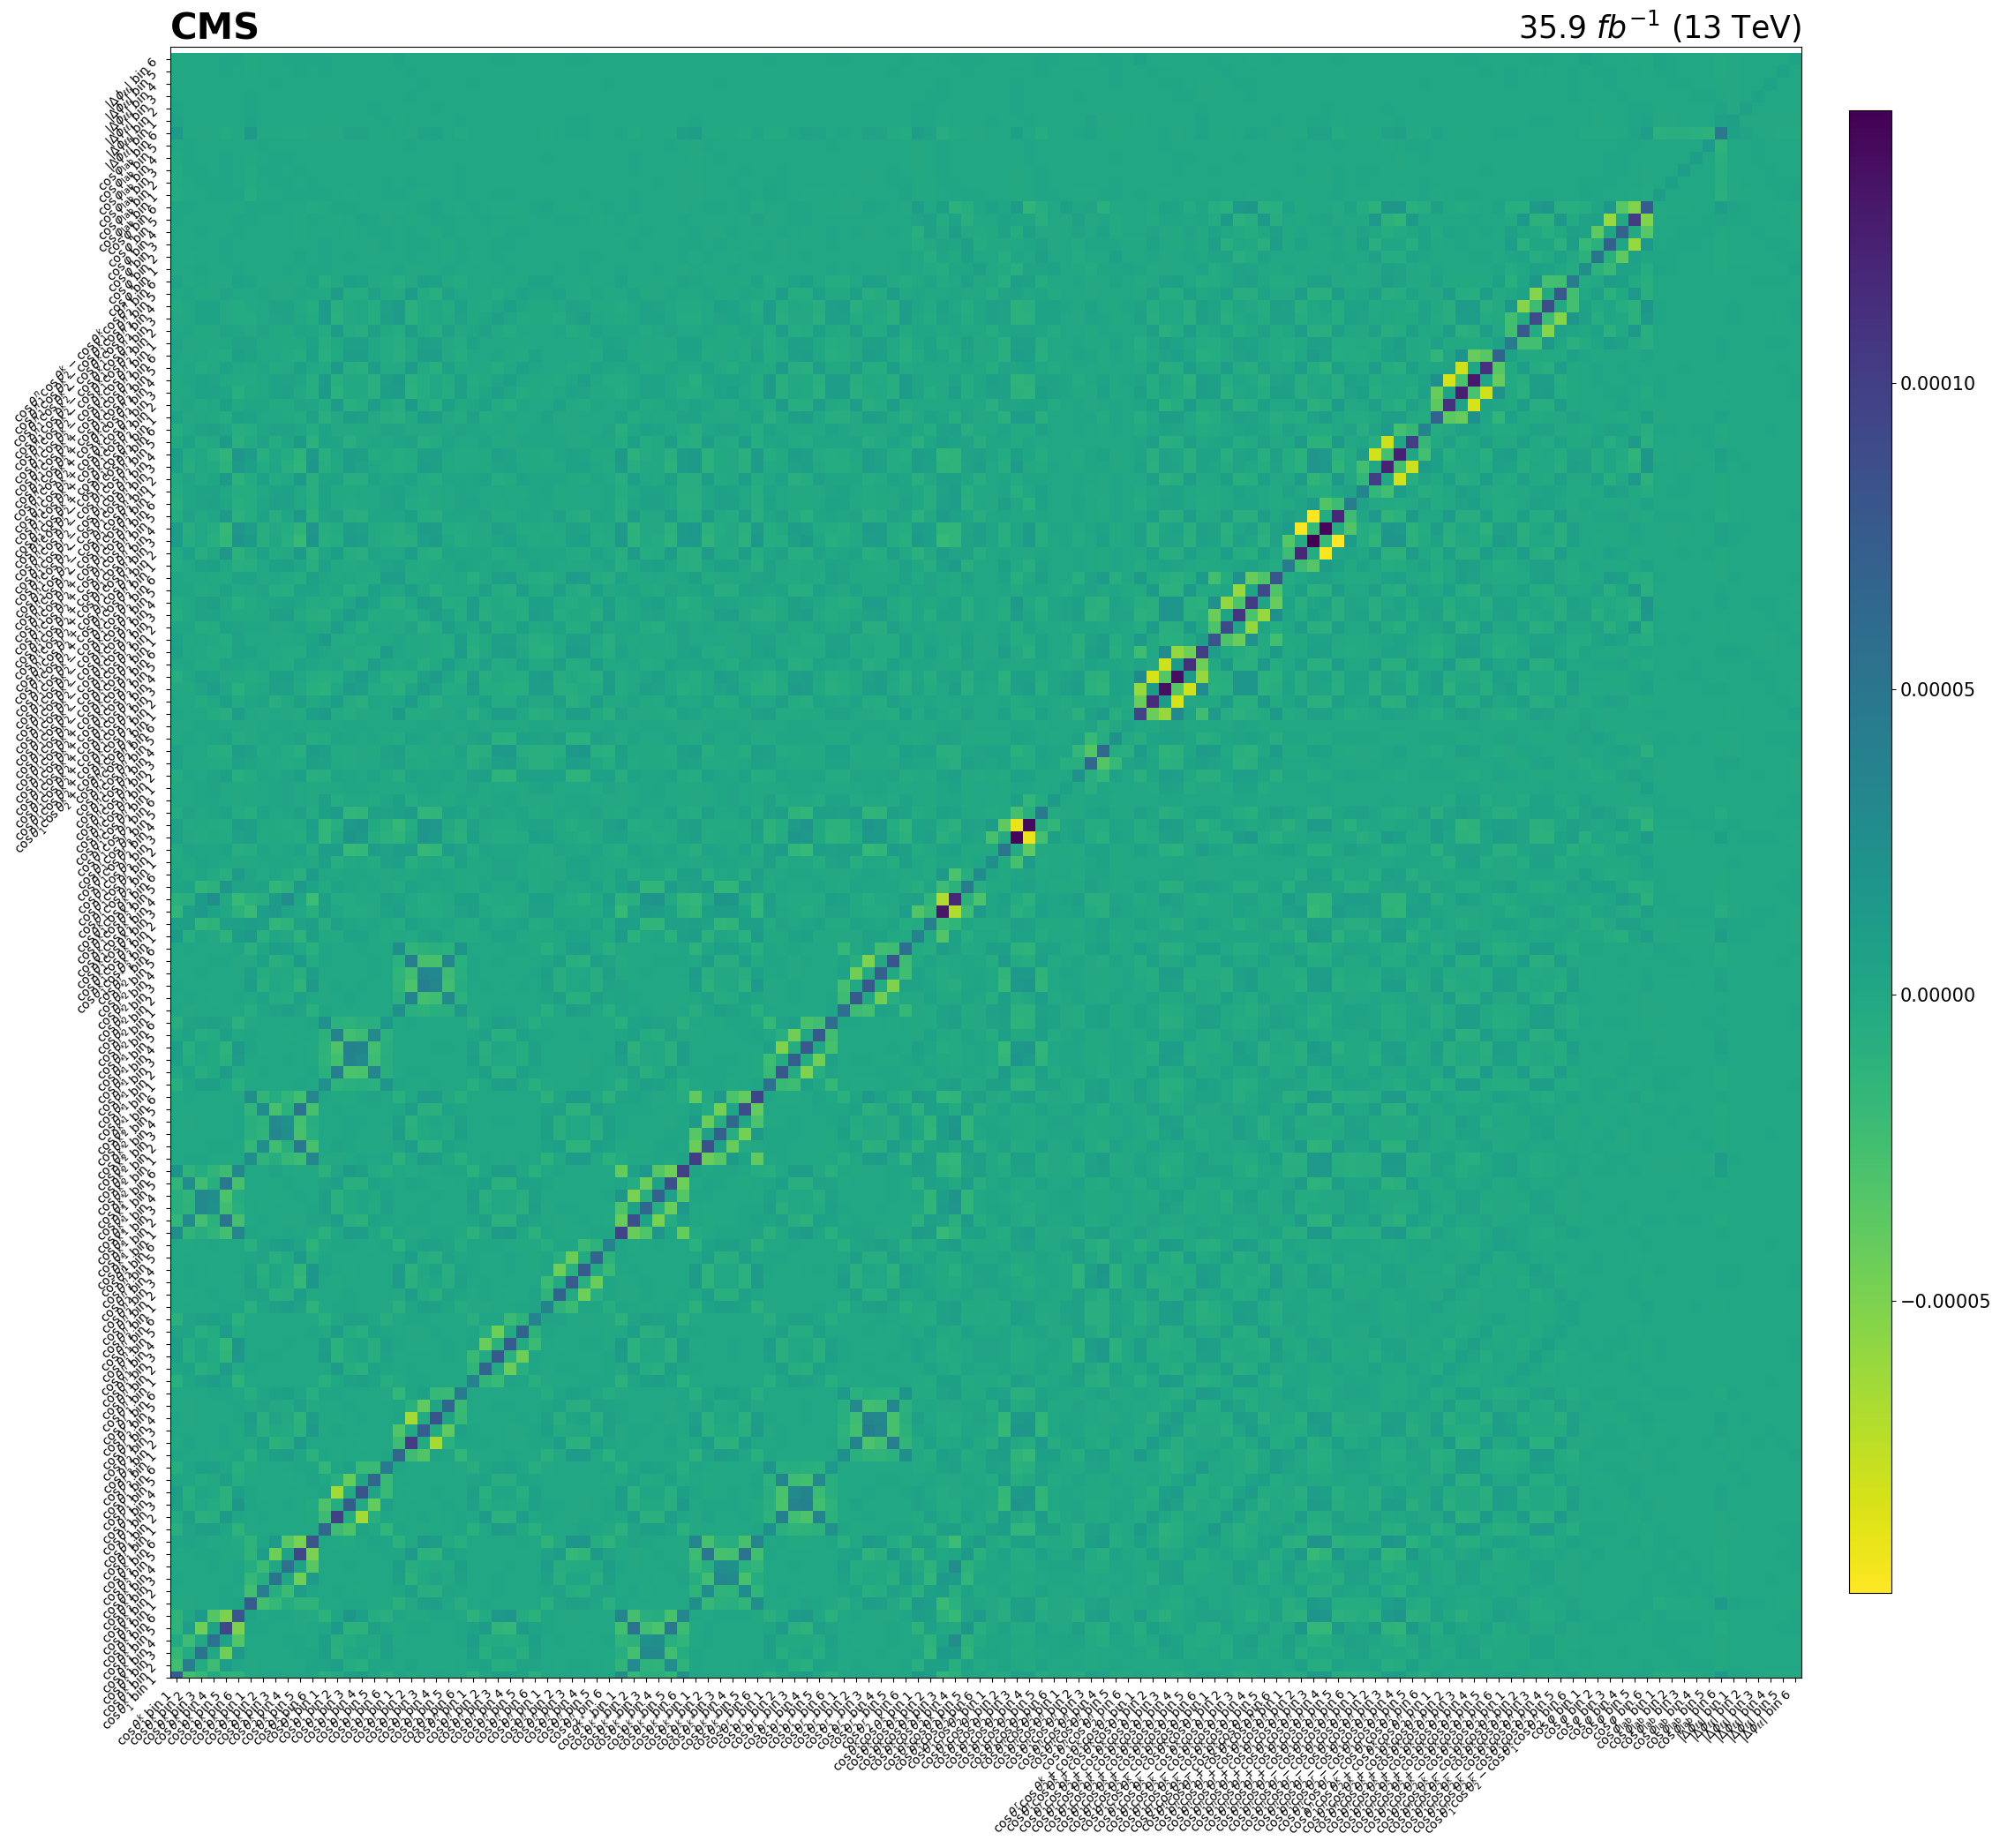

In [291]:
total_stat_mat_from_hep_data = [] 
xy_labels = []

# opening the CSV file
with open('HEPData-ins1742786-v1-Statistical_covariance_matrix.csv', mode ='r')as file:
   
    # reading the CSV file
    csvFile = csv.reader(file)

    # displaying the contents of the CSV file
    for lines in csvFile:
        if not len(lines) == 3 : continue
        if not '$' in lines[0] : continue

        xy_labels.append(str(lines[0]))
        total_stat_mat_from_hep_data.append(np.double(lines[2]))
        
xy_labels = np.reshape(xy_labels, (-1, 132));        

fig, axs = plt.subplots(1, 1, figsize=(24,24))

total_stat_mat_from_hep_data = np.array(total_stat_mat_from_hep_data)
total_stat_mat_from_hep_data = np.reshape(total_stat_mat_from_hep_data, (-1, 132))
#norm_stat = colors.Normalize(vmin=total_stat_mat_from_hep_data.min(), vmax=total_stat_mat_from_hep_data.max())

im = axs.imshow(total_stat_mat_from_hep_data, cmap='viridis_r')

axs.set_title('CMS', fontsize=30, fontweight='bold', loc="left")
axs.set_title('35.9 $fb^{-1}$ (13 TeV)', fontsize=25, loc="right")

axs.set_xticks(np.arange(0, 132))
axs.set_xticklabels(xy_labels[0], rotation=45, ha='right')

axs.set_yticks(np.arange(0, 132))
axs.set_yticklabels(xy_labels[0], rotation=45, ha='right')

#axs.colorbar()
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
axs.set_ylim(0, 132)
#plt.savefig('stat_matrix_from_hep_data.pdf')

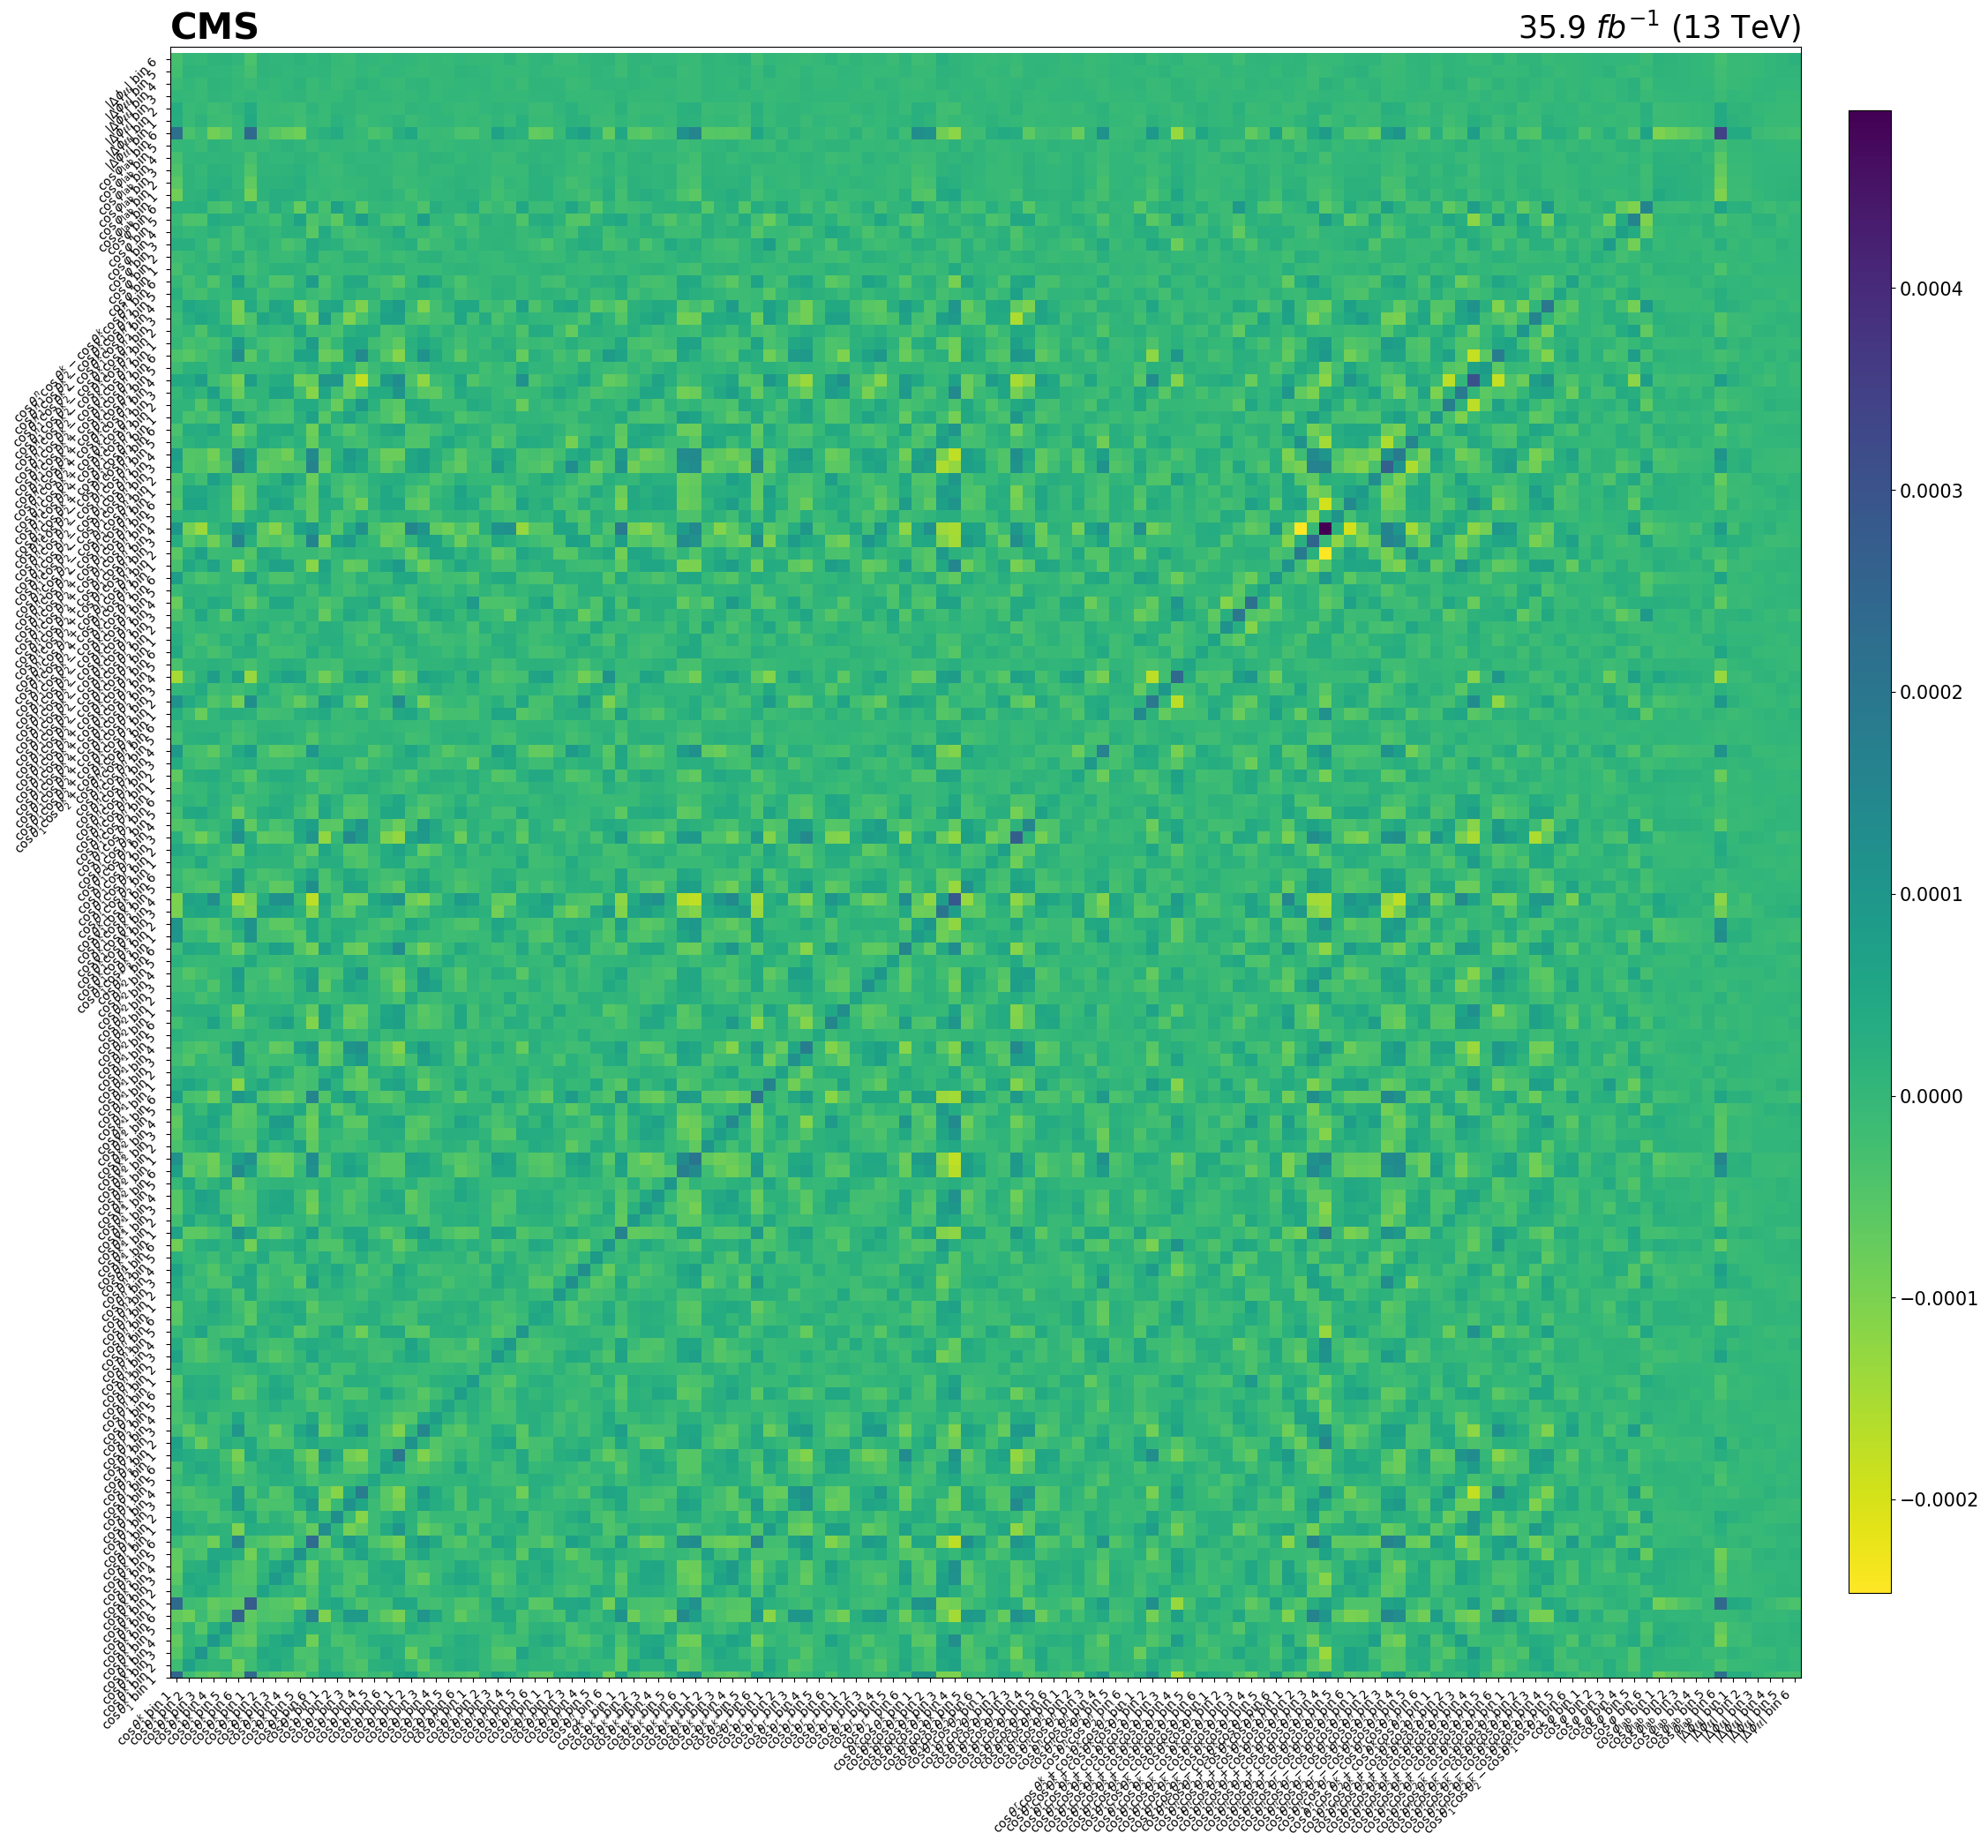

In [95]:
total_syst_mat_from_hep_data = [] 
xy_labels = []

# opening the CSV file
with open('HEPData-ins1742786-v1-Systematic_covariance_matrix.csv', mode ='r')as file:
   
    # reading the CSV file
    csvFile = csv.reader(file)

    # displaying the contents of the CSV file
    for lines in csvFile:
        if not len(lines) == 3 : continue
        if not '$' in lines[0] : continue

        xy_labels.append(str(lines[0]))
        total_syst_mat_from_hep_data.append(np.double(lines[2]))
        
xy_labels = np.reshape(xy_labels, (-1, 132));        

fig, axs = plt.subplots(1, 1, figsize=(24,24))

total_syst_mat_from_hep_data = np.array(total_syst_mat_from_hep_data)
total_syst_mat_from_hep_data = np.reshape(total_syst_mat_from_hep_data, (-1, 132))
#norm_syst = colors.Normalize(vmin=total_syst_mat_from_hep_data.min(), vmax=total_syst_mat_from_hep_data.max())

im = axs.imshow(total_syst_mat_from_hep_data, cmap='viridis_r')

axs.set_title('CMS', fontsize=30, fontweight='bold', loc="left")
axs.set_title('35.9 $fb^{-1}$ (13 TeV)', fontsize=25, loc="right")

axs.set_xticks(np.arange(0, 132))
axs.set_xticklabels(xy_labels[0], rotation=45, ha='right')

axs.set_yticks(np.arange(0, 132))
axs.set_yticklabels(xy_labels[0], rotation=45, ha='right')

#axs.colorbar()
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
axs.set_ylim(0, 132)
#plt.savefig('syst_matrix_from_hep_data.pdf')

finalcov = np.add( total_stat_mat_from_hep_data, total_syst_mat_from_hep_data )

std_devs = np.sqrt(np.diag(finalcov))
inv_std_devs = 1.0 / std_devs
inv_std_devs_matrix = np.diag(inv_std_devs)
finalcov = inv_std_devs_matrix @ finalcov @ inv_std_devs_matrix

In [96]:
# Create a ROOT file and TH2F
root_file = ROOT.TFile("covariance_matrix/statistical_covariance_matrix.root", "RECREATE")
histogram = ROOT.TH2D("covariance_matrix", "Statistical Covariance Matrix", 
                      132, 0, 132, 132, 0, 132)

# Fill the histogram with the matrix values
for i in range(132):
    for j in range(132):
        histogram.SetBinContent(i+1, j+1, finalcov[i, j])

# Write the histogram to the ROOT file
histogram.Write()

# Close the ROOT file
root_file.Close()

In [97]:
hepdata_stat_cov_matrix = uproot.open("covariance_matrix/statistical_covariance_matrix.root")

In [98]:
np.set_printoptions(threshold=10000)
print(hepdata_stat_cov_matrix['covariance_matrix'].to_numpy())

(array([[ 1.        , -0.23189458, -0.31132693, ..., -0.23800555,
        -0.39743416, -0.40486771],
       [-0.23189458,  1.        ,  0.09863707, ...,  0.0346698 ,
         0.26055169,  0.04590648],
       [-0.31132693,  0.09863707,  1.        , ..., -0.13931456,
         0.15964646, -0.01917827],
       ...,
       [-0.23800555,  0.0346698 , -0.13931456, ...,  1.        ,
         0.04918994,  0.15098394],
       [-0.39743416,  0.26055169,  0.15964646, ...,  0.04918994,
         1.        ,  0.39906548],
       [-0.40486771,  0.04590648, -0.01917827, ...,  0.15098394,
         0.39906548,  1.        ]]), array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  

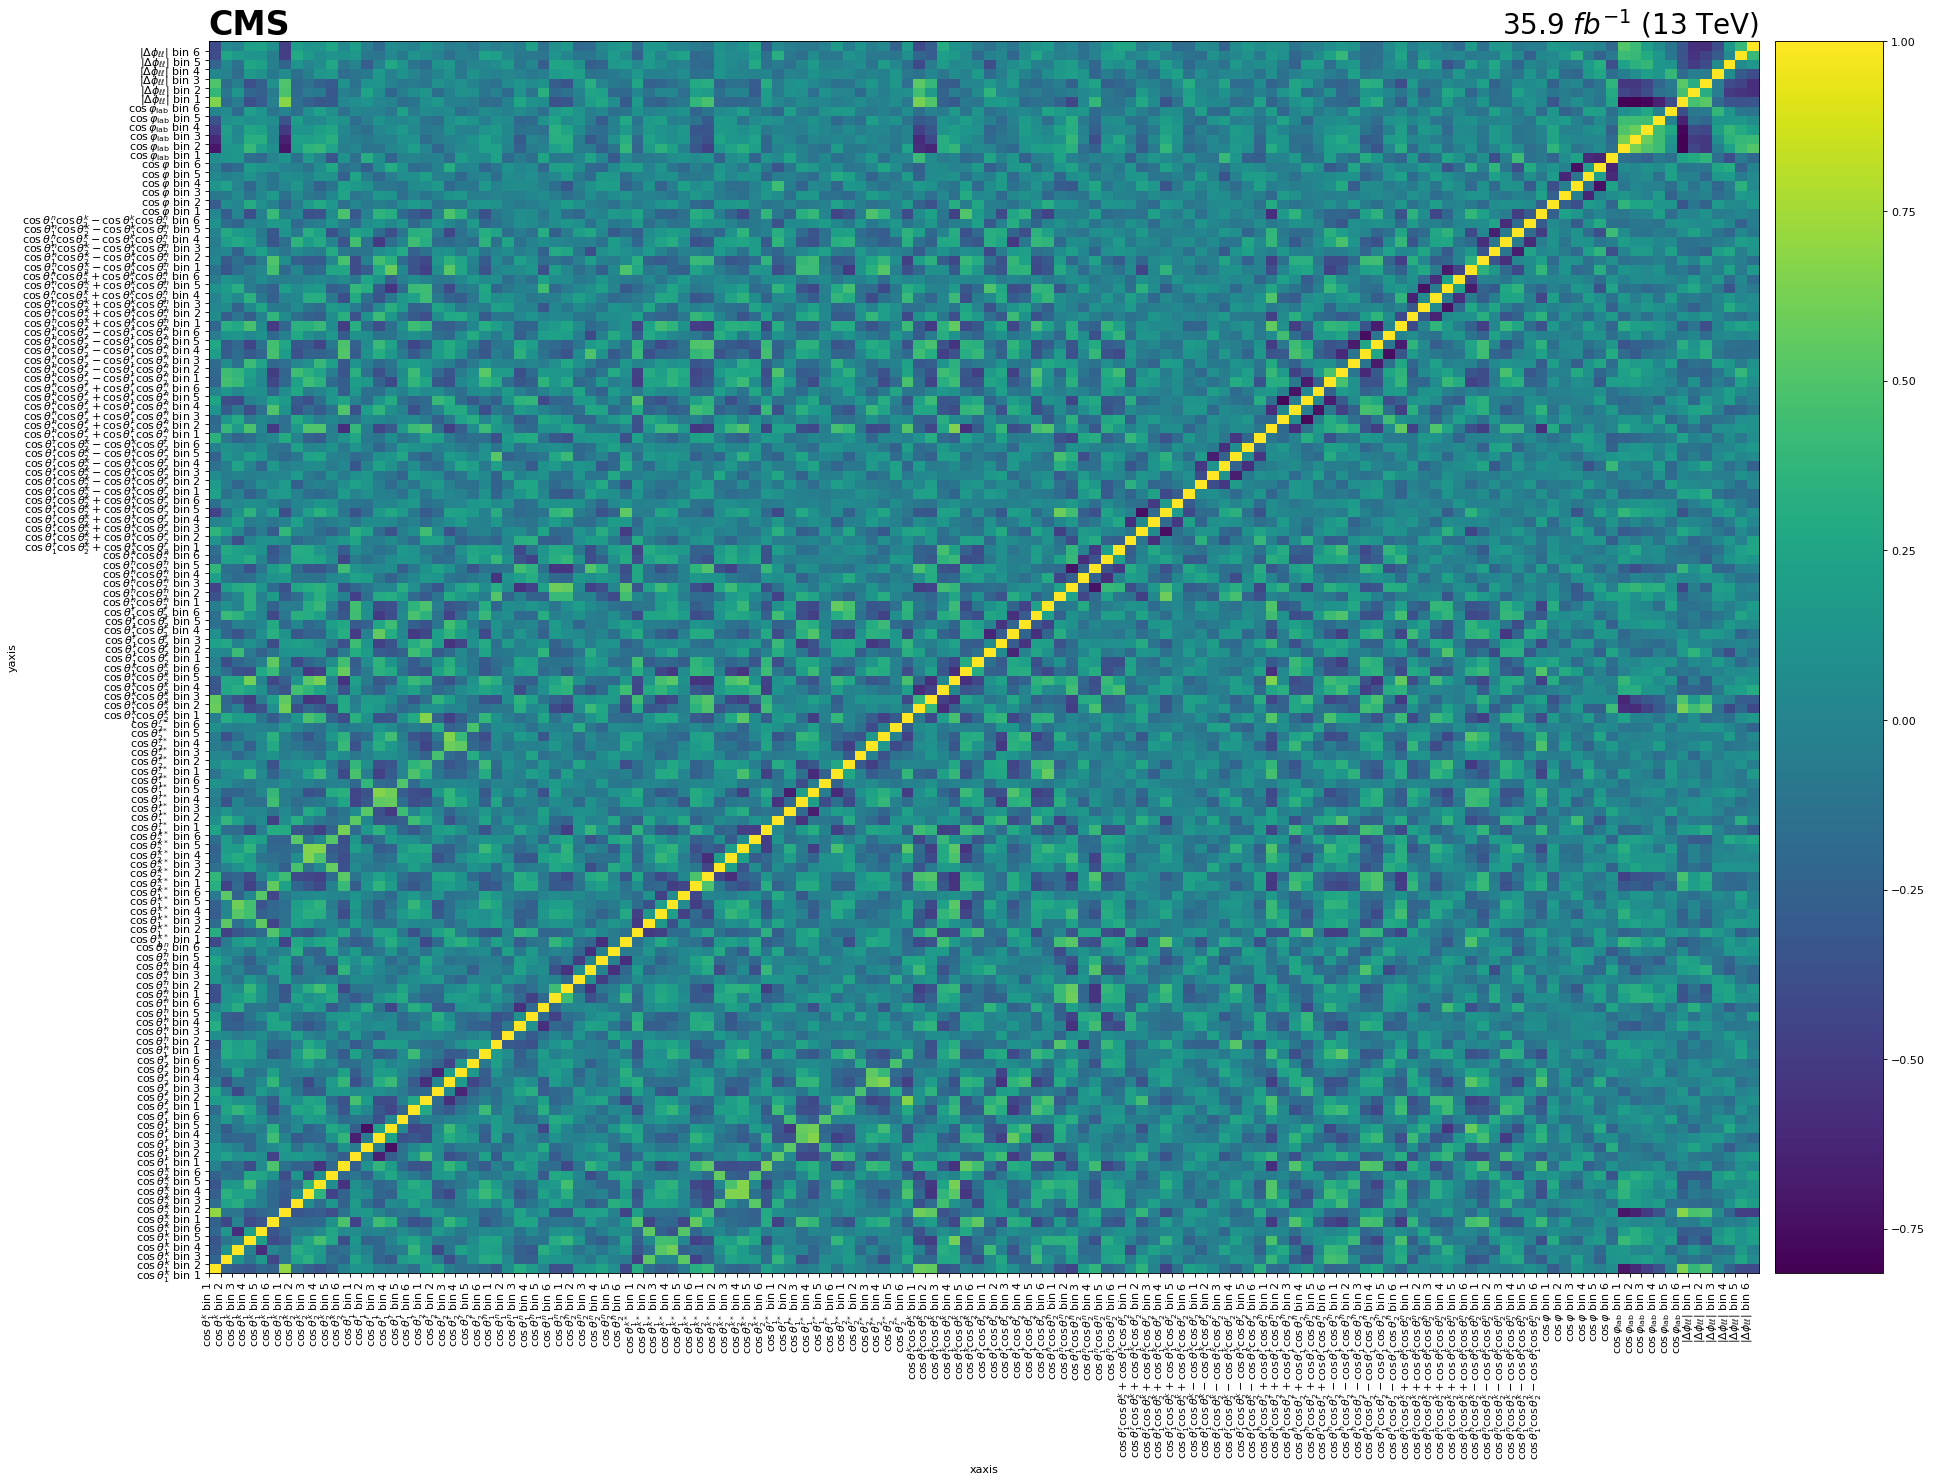

In [99]:
plt.figure(figsize=(25, 20), dpi=80)
hepdata_stat_cov_matrix['covariance_matrix'].to_hist().plot2d()
plt.title('CMS', fontsize=30, fontweight='bold', loc="left")
plt.title('35.9 $fb^{-1}$ (13 TeV)', fontsize=25, loc="right")

plt.yticks(ticks=range(len(xy_labels[0])), labels=xy_labels[0], rotation=0);
plt.xticks(ticks=range(len(xy_labels[0])), labels=xy_labels[0], rotation=90);
plt.savefig('finalcov.pdf')

In [292]:
# Mapping to connect sorting order with filenames in the directory
filenames = [
    "costheta_{1}^{k}.csv",
    "costheta_{2}^{k}.csv",
    "costheta_{1}^{r}.csv",
    "costheta_{2}^{r}.csv",
    "costheta_{1}^{n}.csv",
    "costheta_{2}^{n}.csv",
    "costheta_{1}^{k_}.csv",
    "costheta_{2}^{k_}.csv",
    "costheta_{1}^{r_}.csv",
    "costheta_{2}^{r_}.csv",    
    "costheta_{1}^{k}costheta_{2}^{k}.csv",
    "costheta_{1}^{r}costheta_{2}^{r}.csv",
    "costheta_{1}^{n}costheta_{2}^{n}.csv",
    "c_{1}^{r}c_{2}^{k}+c_{1}^{k}c_{2}^{r}.csv", 
    "c_{1}^{r}c_{2}^{k}-c_{1}^{k}c_{2}^{r}.csv", 
    "c_{1}^{n}c_{2}^{r}+c_{1}^{r}c_{2}^{n}.csv",
    "c_{1}^{n}c_{2}^{r}-c_{1}^{r}c_{2}^{n}.csv", 
    "c_{1}^{n}c_{2}^{k}+c_{1}^{k}c_{2}^{n}.csv",
    "c_{1}^{n}c_{2}^{k}-c_{1}^{k}c_{2}^{n}.csv", 
    "cosvarphi.csv",
    "cosvarphi_{mathrm{lab}}.csv",
    "_Deltaphi_{ellell}_.csv",
]

In [293]:
# Define the base directory and derive the root directory
base_dir = "HEPData-ins1742786-v1-csv"
root_dir = base_dir.replace("-csv", "-root")

# Create the root directory if it doesn't exist
os.makedirs(root_dir, exist_ok=True)

# Process each CSV file in the base directory
for filename in filenames:
    if filename.endswith(".csv"):
        # Define full CSV file path and corresponding ROOT file path
        csv_path = os.path.join(base_dir, filename)
        root_path = os.path.join(root_dir, f"{filename.replace('.csv', '')}.root")

        # Load the CSV file, skipping metadata lines
        data = pd.read_csv(csv_path, skiprows=8)  # Adjusted to skip the first 8 lines

        # Extract columns
        bin_edges_low = data[data.keys()[1]].values
        bin_edges_high = data[data.keys()[2]].values
        diff_cross_section = data[data.keys()[3]].values
        stat_uncert = data[data.keys()[4]].values
        syst_uncert = data[data.keys()[6]].values

        # Combine statistical and systematic uncertainties in quadrature
        total_uncert = np.sqrt(stat_uncert**2 + syst_uncert**2)

        # Define bin edges
        bin_edges = np.concatenate((bin_edges_low, [bin_edges_high[-1]]))

        # Create a histogram with variable bin edges and Weight() storage
        histogram = hist.Hist(hist.axis.Variable(bin_edges, name="cosθ₁^k"), storage=hist.storage.Weight())

        # Prepare structured data with values and variances
        values_with_variances = np.array(
            [(val, var**2) for val, var in zip(diff_cross_section, total_uncert)],
            dtype=[("value", "f8"), ("variance", "f8")]
        )

        # Fill the histogram with the structured array
        histogram[...] = values_with_variances

        print(type(histogram))

        # Plot the histogram with error bars using matplotlib directly
        # plt.errorbar(
        #     histogram.axes[0].centers,  # Bin centers
        #     histogram.view().value,      # Bin values
        #     yerr=np.sqrt(histogram.view().variance),  # Error bars
        #     fmt="o", capsize=3, capthick=1
        # )
        # plt.xlabel(f"{data.keys()[0]}")
        # plt.ylabel(f"{data.keys()[3]}")
        # plt.title("Normalized Differential Cross-Section")
        # plt.show()

        # Save the histogram to a ROOT file using uproot
        with uproot.recreate(root_path) as file:
            file["diff_cross_section"] = normalize_histogram_with_uncertainty(histogram, input_format="hist", output_format="ROOT")

        print(f"Histogram ROOT file created: {root_path}")


<class 'hist.hist.Hist'>
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{1}^{k}.root
<class 'hist.hist.Hist'>
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{2}^{k}.root
<class 'hist.hist.Hist'>
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{1}^{r}.root
<class 'hist.hist.Hist'>
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{2}^{r}.root
<class 'hist.hist.Hist'>
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{1}^{n}.root
<class 'hist.hist.Hist'>
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{2}^{n}.root
<class 'hist.hist.Hist'>
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{1}^{k_}.root
<class 'hist.hist.Hist'>
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{2}^{k_}.root
<class 'hist.hist.Hist'>
Histogram ROOT file created: HEPData-ins1742786-v1-root/costheta_{1}^{r_}.root
<class 'hist.hist.Hist'>
Histogram ROOT file created: HEPData-ins17427

Warning in <TROOT::Append>: Replacing existing TH1: normalized (Potential memory leak).


In [294]:
# Define the input directory and output ROOT file
input_dir = "HEPData-ins1742786-v1-root"
output_file = ROOT.TFile("HEPData-concatenated-histogram.root", "RECREATE")

# Initialize variables for the combined histogram
concatenated_histogram = None
bin_offset = 0  # Tracks the bin index offset as we add more histograms

# Calculate the total number of bins needed by summing bins across all histograms
total_bins = 0
for filename in filenames:
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename.replace(".csv",".root"))
        input_file = ROOT.TFile.Open(file_path)
        if not input_file or input_file.IsZombie():
            print(f"Could not open file {filename}. Skipping...")
            continue
        h_density = input_file.Get("diff_cross_section")
        if h_density:
            total_bins += h_density.GetNbinsX()
        input_file.Close()

print(f"Total bins for concatenated histogram: {total_bins}")

# Create the concatenated histogram with the calculated total number of bins
concatenated_histogram = ROOT.TH1D("concatenated_diff_cross_section", "Concatenated Histogram", total_bins, 0, total_bins)

# Loop through each ROOT file in the directory and fill the concatenated histogram
for filename in filenames:
    if filename.endswith(".csv"):
        # Open the ROOT file
        file_path = os.path.join(input_dir, filename.replace(".csv",".root"))
        input_file = ROOT.TFile.Open(file_path)
        
        # Check if the file opened successfully
        if not input_file or input_file.IsZombie():
            print(f"Could not open file {filename}. Skipping...")
            continue

        # Retrieve the histogram
        h_density = input_file.Get("diff_cross_section")
        if not h_density:
            print(f"Histogram 'diff_cross_section' not found in {filename}. Skipping...")
            input_file.Close()
            continue

        print(f"Processing {filename} with {h_density.GetNbinsX()} bins.")

        # Copy the content of the current histogram to the concatenated histogram
        for bin in range(1, h_density.GetNbinsX() + 1):
            global_bin = bin + bin_offset
            concatenated_histogram.SetBinContent(global_bin, h_density.GetBinContent(bin))
            concatenated_histogram.SetBinError(global_bin, h_density.GetBinError(bin))

        # Update the bin offset
        bin_offset += h_density.GetNbinsX()

        # Close the input file
        input_file.Close()

# Write the concatenated histogram to the output file
output_file.cd()
concatenated_histogram.Write()
output_file.Close()

print("Concatenated histogram saved to HEPData-concatenated-histogram.root")


Total bins for concatenated histogram: 132
Processing costheta_{1}^{k}.csv with 6 bins.
Processing costheta_{2}^{k}.csv with 6 bins.
Processing costheta_{1}^{r}.csv with 6 bins.
Processing costheta_{2}^{r}.csv with 6 bins.
Processing costheta_{1}^{n}.csv with 6 bins.
Processing costheta_{2}^{n}.csv with 6 bins.
Processing costheta_{1}^{k_}.csv with 6 bins.
Processing costheta_{2}^{k_}.csv with 6 bins.
Processing costheta_{1}^{r_}.csv with 6 bins.
Processing costheta_{2}^{r_}.csv with 6 bins.
Processing costheta_{1}^{k}costheta_{2}^{k}.csv with 6 bins.
Processing costheta_{1}^{r}costheta_{2}^{r}.csv with 6 bins.
Processing costheta_{1}^{n}costheta_{2}^{n}.csv with 6 bins.
Processing c_{1}^{r}c_{2}^{k}+c_{1}^{k}c_{2}^{r}.csv with 6 bins.
Processing c_{1}^{r}c_{2}^{k}-c_{1}^{k}c_{2}^{r}.csv with 6 bins.
Processing c_{1}^{n}c_{2}^{r}+c_{1}^{r}c_{2}^{n}.csv with 6 bins.
Processing c_{1}^{n}c_{2}^{r}-c_{1}^{r}c_{2}^{n}.csv with 6 bins.
Processing c_{1}^{n}c_{2}^{k}+c_{1}^{k}c_{2}^{n}.csv wit

In [297]:
h_concatenated_EFT = {}

ctg_values = ['p0', 'p2', 'm2']

h_concatenated = uproot.open("HEPData-concatenated-histogram.root")['concatenated_diff_cross_section;1'].to_hist()
for value in ctg_values:
    h_concatenated_EFT[value] = uproot.open(f'nlo_ctG_root_density/nlo_ctG_{value}_nominal_toppt_default_shape_concatenated.root')['TTbarSpinDensityMatrix;1']['snake_spinCorr_absolute_part_cut_0;1'].to_hist()


In [279]:
#uproot.open(f'nlo_ctG_root_density/nlo_ctG_{value}_nominal_toppt_default_shape_concatenated.root').keys()

In [298]:
#uproot.open(f'nlo_ctG_root_density/nlo_ctG_{value}_nominal_toppt_default_shape_concatenated.root')['TTbarSpinDensityMatrix;1']['b1q_absolute_part_cut_0;1'].to_hist().plot1d()

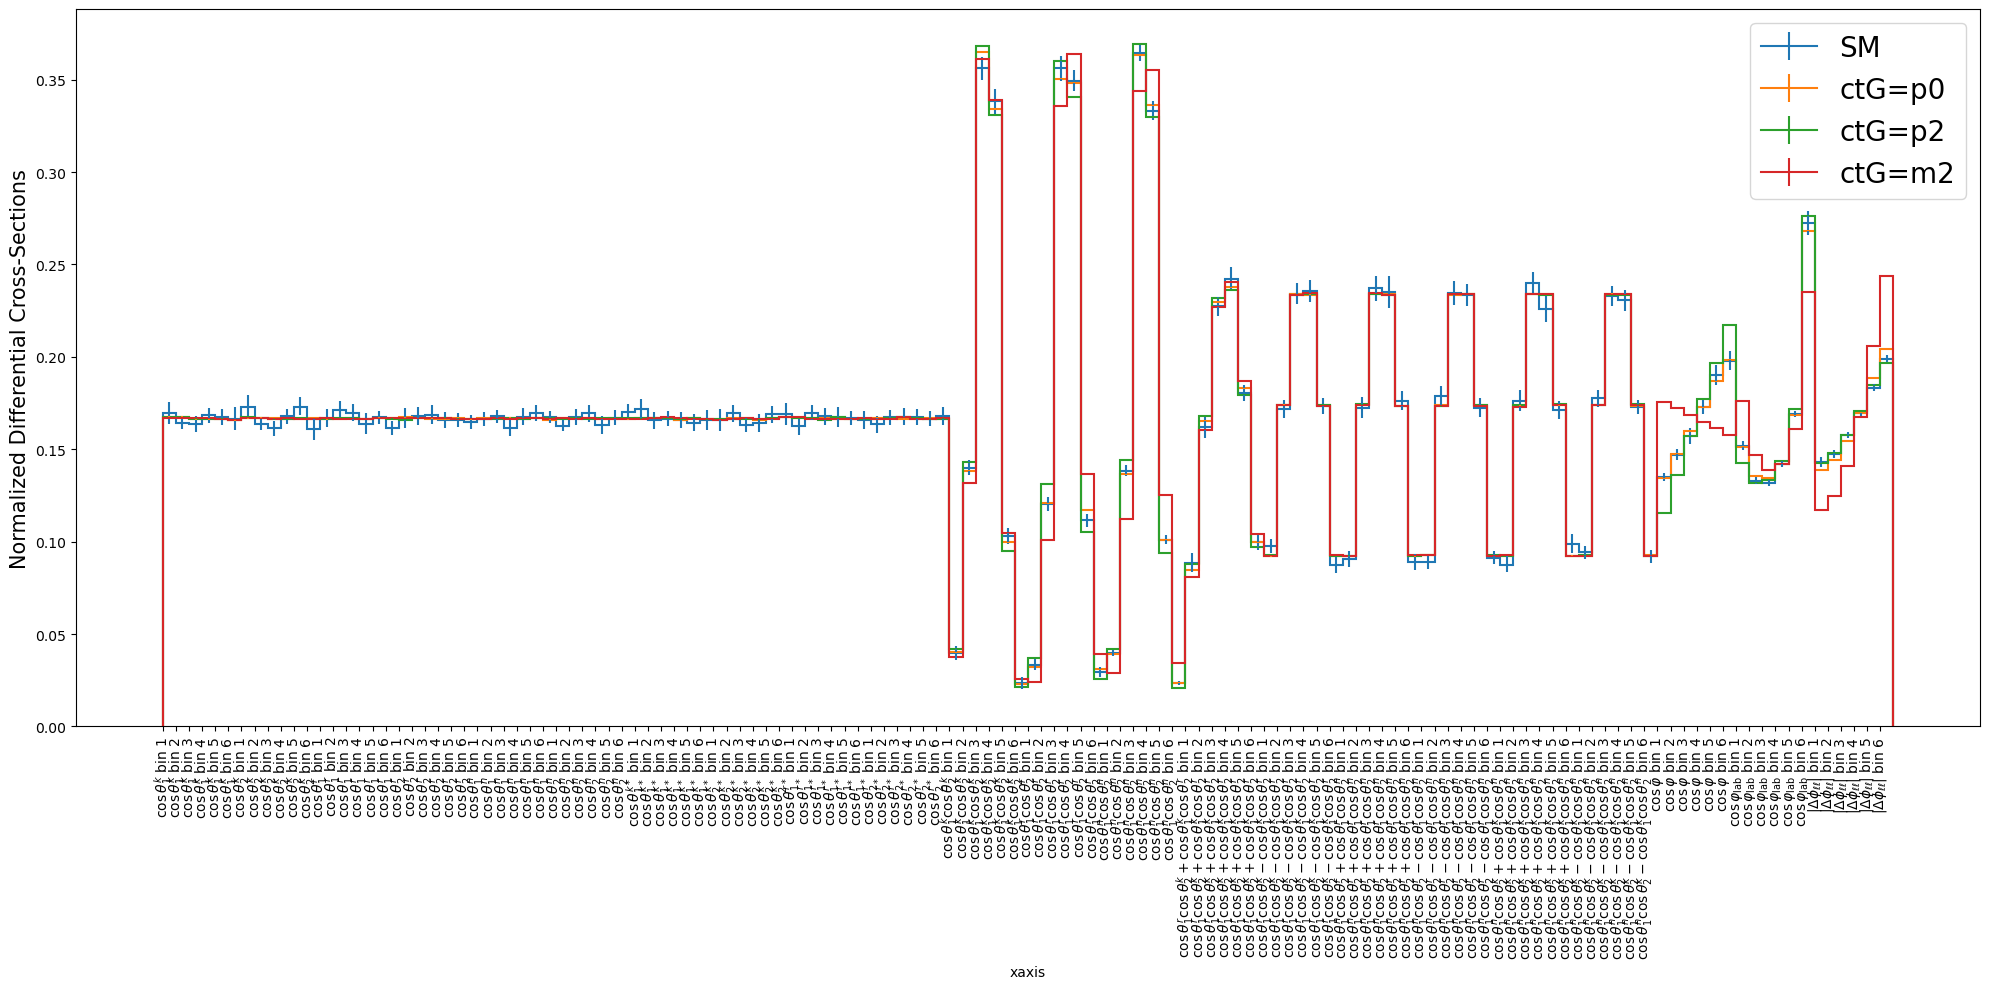

In [299]:
plt.figure(figsize=(20, 10), dpi=100)

h_concatenated.plot1d(label='SM')
for value in h_concatenated_EFT:
    h_concatenated_EFT[value].plot1d(label=f'ctG={value}')

plt.legend(fontsize=20)
plt.ylabel("Normalized Differential Cross-Sections", fontsize=15)
plt.xticks(ticks=range(len(xy_labels[0])), labels=xy_labels[0], rotation=90)
plt.tight_layout()  # Automatically adjusts spacing
plt.savefig("concatenated_histograms.pdf", bbox_inches='tight')  # Ensures labels are not cut


In [18]:
test_hist = uproot.open('nlo_ctG_root/nlo_ctG_m2_nominal_toppt_default_shape.root')
test_hist['TTbarSpinDensityMatrix/b1j_absolute_part_cut_0;1'].name

'b1j_absolute_part_cut_0'

In [14]:
test_hist['TTbarSpinDensityMatrix/b1j_absolute_part_cut_0;1'].axes[0].edges()[0]

-1.0

In [265]:
# Define input and output directories
input_dir = "nlo_ctG_root/"
output_dir = "nlo_ctG_root_density/"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Loop through all .root files in the input directory
for root_file in tqdm(os.listdir(input_dir)):
    if root_file.endswith(".root"):
        input_path = os.path.join(input_dir, root_file)
        output_path = os.path.join(output_dir, root_file)
        
        # Open the input .root file for reading
        with uproot.open(input_path) as infile:

            # Write the normalized histograms to a new .root file using ROOT
            root_outfile = ROOT.TFile(output_path, "RECREATE")  
            root_outfile.mkdir('TTbarSpinDensityMatrix')
            root_outfile.cd('TTbarSpinDensityMatrix')            
            for key in infile.keys():
                
                if (key!=infile.keys()[0]):
                    key_hist=key.split('/')[1].replace(';1', '')
        
                    # Normalize the histogram values with uncertainty propagation
                    h_density = normalize_histogram_with_uncertainty(infile[key], input_format="uproot", output_format="ROOT")
        
                    # Write histogram to the file
                    h_density.Write()

            # Close the output file
            root_outfile.Close()

print("Normalization complete with uncertainty propagation. Normalized files saved to:", output_dir)


100%|██████████| 76/76 [01:00<00:00,  1.26it/s]


Normalization complete with uncertainty propagation. Normalized files saved to: nlo_ctG_root_density/


In [266]:
ctg_values = ['p0', 'p2', 'm2']

for value in ctg_values:
    # Input and output ROOT file names
    input_file_name = f"nlo_ctG_root_density/nlo_ctG_{value}_nominal_toppt_default_shape.root"
    output_file_name = f"nlo_ctG_root_density/nlo_ctG_{value}_nominal_toppt_default_shape_concatenated.root"
    
    # Open the input ROOT file
    input_file = ROOT.TFile.Open(input_file_name, "READ")
    if not input_file or input_file.IsZombie():
        raise FileNotFoundError(f"Could not open input file {input_file_name}")
    
    # Navigate to the directory
    input_dir = input_file.Get("TTbarSpinDensityMatrix")
    if not input_dir or not isinstance(input_dir, ROOT.TDirectory):
        raise RuntimeError("Directory 'TTbarSpinDensityMatrix' not found in the input file")
    
    # Create output file
    output_file = ROOT.TFile(output_file_name, "RECREATE")
    output_dir = output_file.mkdir("TTbarSpinDensityMatrix")
    output_dir.cd()  # Navigate to the created directory
    
    # Histograms to skip
    skip_histograms = [
        "snake_spinCorr_absolute_part_cut_0",
        "snake_spinHeli_absolute_part_cut_0",
        "snake_spinDens_absolute_part_cut_0",
        "snake_spinColl_absolute_part_cut_0",
        "spin_coeff_absolute_part_cut_0",
        "b1k_shape_part_cut_0",
        "b2k_shape_part_cut_0",
        "b1r_shape_part_cut_0",
        "b2r_shape_part_cut_0",
        "b1n_shape_part_cut_0",
        "b2n_shape_part_cut_0",
        "b1j_shape_part_cut_0",
        "b2j_shape_part_cut_0",
        "b1q_shape_part_cut_0",
        "b2q_shape_part_cut_0",
        "ckk_shape_part_cut_0",
        "crr_shape_part_cut_0",
        "cnn_shape_part_cut_0",
        "cP_rk_shape_part_cut_0",
        "cM_rk_shape_part_cut_0",
        "cP_nr_shape_part_cut_0",
        "cM_nr_shape_part_cut_0",
        "cP_nk_shape_part_cut_0",
        "cM_nk_shape_part_cut_0",
        "cHel_shape_part_cut_0",
        "cLab_shape_part_cut_0",
        "LL_dPhi_shape_part_cut_0",
        "snake_spinCorr_shape_part_cut_0",
        "sumWgt_noCut",
        "sumEvt_noCut"
    ]
    
    # Key to replace with the concatenated histogram
    replace_histogram_key = "snake_spinCorr_absolute_part_cut_0"
    
    # Initialize variables for the concatenated histogram
    concatenated_histogram = None
    bin_offset = 0  # Tracks the bin index offset as we add more histograms
    
    # Collect all keys in the directory
    keys = [key.GetName() for key in input_dir.GetListOfKeys()]
    
    # Calculate total bins for concatenated histogram
    total_bins = 0
    for key in keys:
        if key in skip_histograms:
            continue
        histogram = input_dir.Get(key)
        if isinstance(histogram, ROOT.TH1) and histogram.GetNbinsX() > 0:
            total_bins += histogram.GetNbinsX()
    
    # Create concatenated histogram
    concatenated_histogram = ROOT.TH1D(
        replace_histogram_key,
        "Concatenated Histogram",
        total_bins,
        0,
        total_bins
    )
    
    # Fill concatenated histogram
    for key in keys:
        if key in skip_histograms:
            continue
        histogram = input_dir.Get(key)
        if isinstance(histogram, ROOT.TH1) and histogram.GetNbinsX() > 0:
            for bin in range(1, histogram.GetNbinsX() + 1):
                global_bin = bin + bin_offset
                concatenated_histogram.SetBinContent(global_bin, histogram.GetBinContent(bin))
                concatenated_histogram.SetBinError(global_bin, histogram.GetBinError(bin))
            bin_offset += histogram.GetNbinsX()
    
    # Write all histograms to the output directory
    output_dir.cd()
    for key in keys:
        histogram = input_dir.Get(key)
        if key == replace_histogram_key:
            output_dir.WriteObject(concatenated_histogram, key)
        elif isinstance(histogram, ROOT.TH1):
            histogram.Write()
    
    # Close files
    input_file.Close()
    output_file.Close()
    
    print(f"Concatenated histogram saved to {output_file_name}")


Concatenated histogram saved to nlo_ctG_root_density/nlo_ctG_p0_nominal_toppt_default_shape_concatenated.root
Concatenated histogram saved to nlo_ctG_root_density/nlo_ctG_p2_nominal_toppt_default_shape_concatenated.root
Concatenated histogram saved to nlo_ctG_root_density/nlo_ctG_m2_nominal_toppt_default_shape_concatenated.root


In [267]:
#file_snake_m2_og = uproot.open('nlo_ctG_root/nlo_ctG_m2_nominal_toppt_default_shape.root')
file_snake_p2 = uproot.open('nlo_ctG_root/nlo_ctG_p2_nominal_toppt_default_shape.root')
file_snake_m2 = uproot.open('nlo_ctG_root_density/nlo_ctG_p0_nominal_toppt_default_shape_concatenated.root')

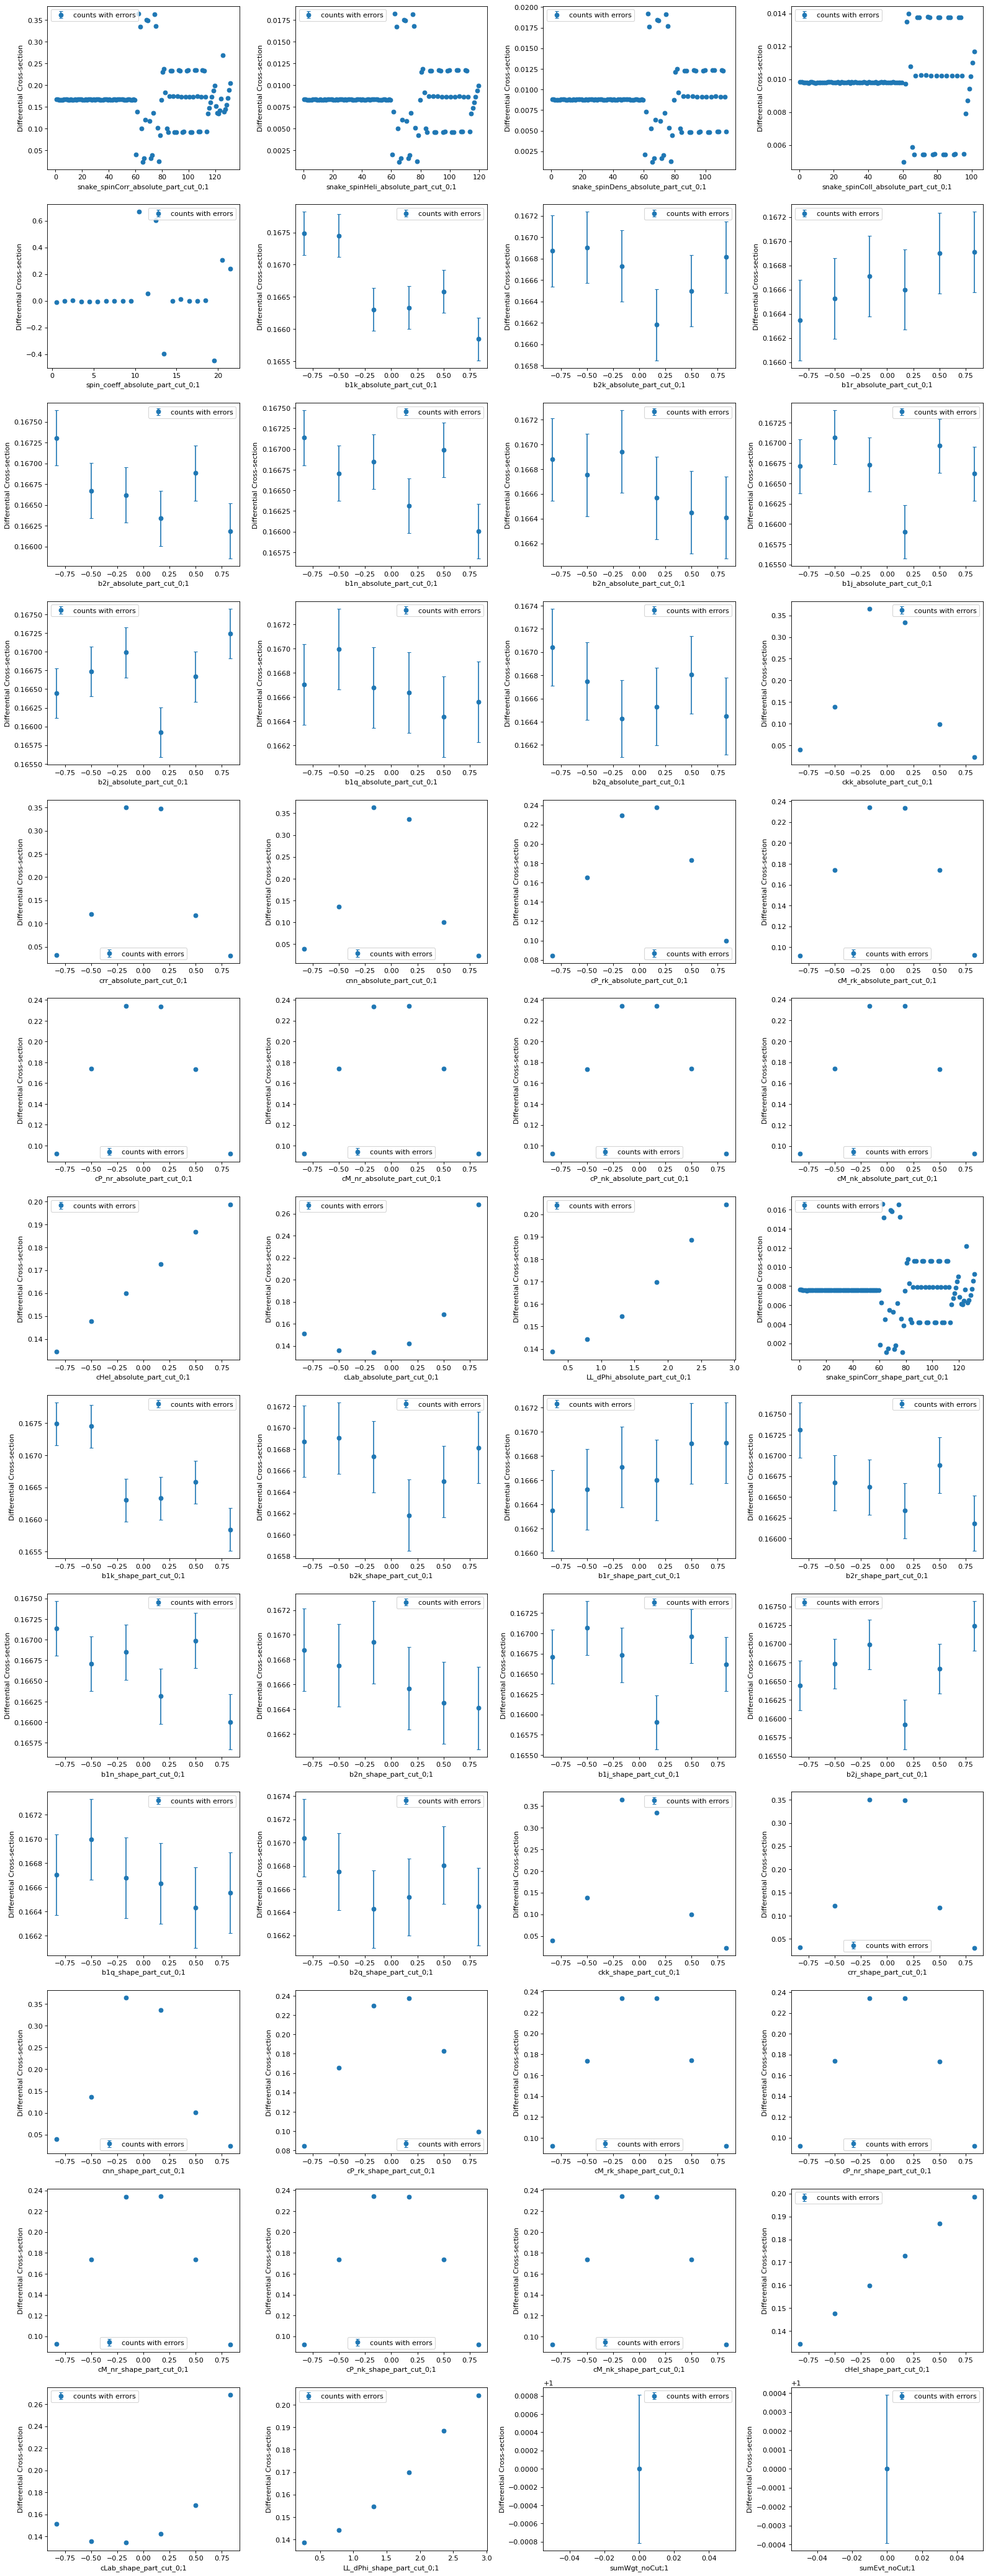

In [268]:
# Determine the number of keys to set up grid size
keys = list(file_snake_m2['TTbarSpinDensityMatrix'].keys())
n_keys = len(keys)

# Set up the subplot grid: Choose rows and columns for better visualization
n_cols = 4  # Adjust this as needed (e.g., 3 columns)
n_rows = (n_keys + n_cols - 1) // n_cols  # Calculate rows needed based on number of columns

# Create a large canvas with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), dpi=80)
axes = axes.flatten()  # Flatten to easily iterate over for 1D indexing

# Loop through each histogram key and plot it on a separate subplot
for i, key in enumerate(keys):
    # Retrieve histogram data
    h_density = file_snake_m2['TTbarSpinDensityMatrix'][key].to_hist()
    values = h_density.values()
    variances = h_density.variances()
    errors = np.sqrt(variances)  # Calculate standard deviation (square root of variance)
    bin_edges = h_density.axes[0].edges  # Get bin edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers for plotting

    # Plot with error bars in the respective subplot
    ax = axes[i]
    ax.errorbar(bin_centers, values, yerr=errors, fmt='o', capsize=3, label='counts with errors')
    ax.set_xlabel(key)
    ax.set_ylabel('Differential Cross-section')
    #ax.set_title(f'Histogram for {key}')
    ax.legend()

# Hide any extra subplots if n_keys is less than n_rows * n_cols
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig('inspect_snake_input.png')